# 목차

* 평가문항
* 프로젝트:한영 번역기 만들기
* Step 1. 데이터 다운로드
* Step 2. 데이터 정제
* Step 3. 데이터 토큰화
* Step 4. 모델 설계
* Step 5. 훈련하기
* 회고
* Reference

# 평가문항

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.

> 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

2. Attentional Seq2seq 모델이 정상적으로 구동된다.

> seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.

3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.

> 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

# 프로젝트: 한영 번역기 만들기

## 라이브러리 불러오기

In [ ]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [ ]:
from konlpy.tag import Mecab

In [ ]:
# 코랩에서 한글 나눔체를 다운로드 받는 코드

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-u

In [ ]:
# 한글 폰트를 사용하기 위한 코드

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


# Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [ ]:
! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


## 데이터 불러오기

In [ ]:
path_train_ko = os.getenv('HOME') + '/aiffel/s2s_translation/korean-english-park.train.ko'
path_train_en = os.getenv('HOME') + '/aiffel/s2s_translation/korean-english-park.train.en'


In [ ]:
with open(path_train_ko, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [ ]:
train_kr = raw[:]
print(train_kr[:100:20])

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.', '"경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."', '수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.', '또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.']


In [ ]:
with open(path_train_en, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [ ]:
train_en = raw[:]
print(train_en[:100:20])

['Much of personal computing is about "can you top this?"', 'Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.', '“Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.', 'Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.', 'Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.']


In [ ]:
# 한국어 문장과 영어 문장을 연결해준다.

corpus = []
for i in range(len(train_kr)):
  pair = (train_kr[i], train_en[i]) # 두 문장을 리스트가 아닌 튜플로 묶는다.
  corpus.append(pair)               # 이후 set()에 corpus를 넣어주기 위함.

print(corpus[0])

('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', 'Much of personal computing is about "can you top this?"')


# Step 2. 데이터 정제

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

## 중복된 값 제거

set() 의 특성을 이용해 중복된 값을 제거한다.

In [ ]:
cleaned_corpus = set(corpus)

In [ ]:
print("처음 주어진 학습 데이터의 수:",len(corpus))
print("중복을 제거한 후 학습 데이터의 수:",len(cleaned_corpus))

처음 주어진 학습 데이터의 수: 94123
중복을 제거한 후 학습 데이터의 수: 78968


In [ ]:
cleaned_corpus = list(cleaned_corpus)
print(cleaned_corpus[1][0])
print(cleaned_corpus[1][1])

Ben Bernanke 밴 버냉키, 미 연방준비위원회 위원장
Fed chairman Ben Bernanke is telling Congress today it needs to act to help absorb some of the shock.


## 데이터 전처리

In [ ]:
mecab = Mecab()

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence, ko=False, en=False):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 알파벳, 숫자 ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다.
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()

  # 토큰화
  if ko:
    sentence = mecab.morphs(sentence) # 한글
        
  if en:
    sentence = sentence.split()      # 영문

  # 문장의 양 끝에 시작 토큰과 종료 토큰 삽입
  if en:
    sentence.insert(0,'<start> ')
    sentence.append(' <end>')

  return sentence

위 함수에서 디코더에 해당하는 부분에만 시작, 종료 토큰을 넣는다.

아래에서는 데이터의 길이로 나누어 너무 긴 데이터는 제외한다.

In [ ]:
# 전처리 적용
# 문장의 길이가 40 이하인 데이터만 선별

kor_corpus=[]
eng_corpus=[]

for i in range(len(cleaned_corpus)):
    if (len(cleaned_corpus[i][0]) < 41 and len(cleaned_corpus[i][1].split()) < 41):
        kor_corpus.append(preprocess_sentence(cleaned_corpus[i][0], ko=True))

        eng_corpus.append(preprocess_sentence(cleaned_corpus[i][1], en=True))

In [ ]:
print(len(kor_corpus), kor_corpus[1])

15897 ['보험', '사', '들', '은', '보험', '적용', '범위', '에', '대해', '일관', '된', '기준', '을', '갖', '고', '있', '지', '않', '다', '.']


In [ ]:
print(len(eng_corpus), eng_corpus[1])

15897 ['<start> ', 'insurers', 'have', 'no', 'consistent', 'standards', 'on', 'coverage', '.', ' <end>']


# Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='', filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

단어의 수 1만개로 두고 사용

In [ ]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

In [ ]:
print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 17619
English Vocab Size: 17307


In [ ]:
print(enc_tensor.shape, dec_tensor.shape)

(15897, 25) (15897, 52)


In [ ]:
enc_tensor

array([[8883, 6074, 3940, ...,    0,    0,    0],
       [2651,  278,   15, ...,    0,    0,    0],
       [1214,    8, 1041, ...,    0,    0,    0],
       ...,
       [  69,  111,   62, ...,    0,    0,    0],
       [  95, 1870, 8547, ...,    0,    0,    0],
       [  54,    2, 2596, ...,    0,    0,    0]], dtype=int32)

In [ ]:
dec_tensor

array([[   2, 1814, 1063, ...,    0,    0,    0],
       [   2, 9394,   26, ...,    0,    0,    0],
       [   2,   44,  223, ...,    0,    0,    0],
       ...,
       [   2,   85,    5, ...,    0,    0,    0],
       [   2,  280,    5, ...,    0,    0,    0],
       [   2,  116,    4, ...,    0,    0,    0]], dtype=int32)

# Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512
dropout = 0.5

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, dropout)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, dropout)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 17308)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# Step 5. 훈련하기

## Optimizer & Loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 모델 훈련하기

아래에서 train_step 구현 후 훈련 시작

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start> ']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 249/249 [02:13<00:00,  1.87it/s, Loss 0.9932]


## 성능 평가(1)

In [ ]:
# 전처리 함수(2)
def preprocess_sentence_2(sentence, ko=False, en=False):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 알파벳, 숫자 ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다.
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()

  # 토큰화
  if ko:
    sentence = mecab.morphs(sentence) # 한글
        
  if en:
    sentence = sentence.split()      # 영문

  # 문장의 양 끝에 시작 토큰과 종료 토큰 삽입
  if en:
    sentence = '<start> ' + sentence + ' <end>'

  return sentence

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_2(sentence, ko=True)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start> ']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == ' <end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the obamas are scheduled to be published .  <end> 


/tmp/ipykernel_56/3465842361.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_56/3465842361.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


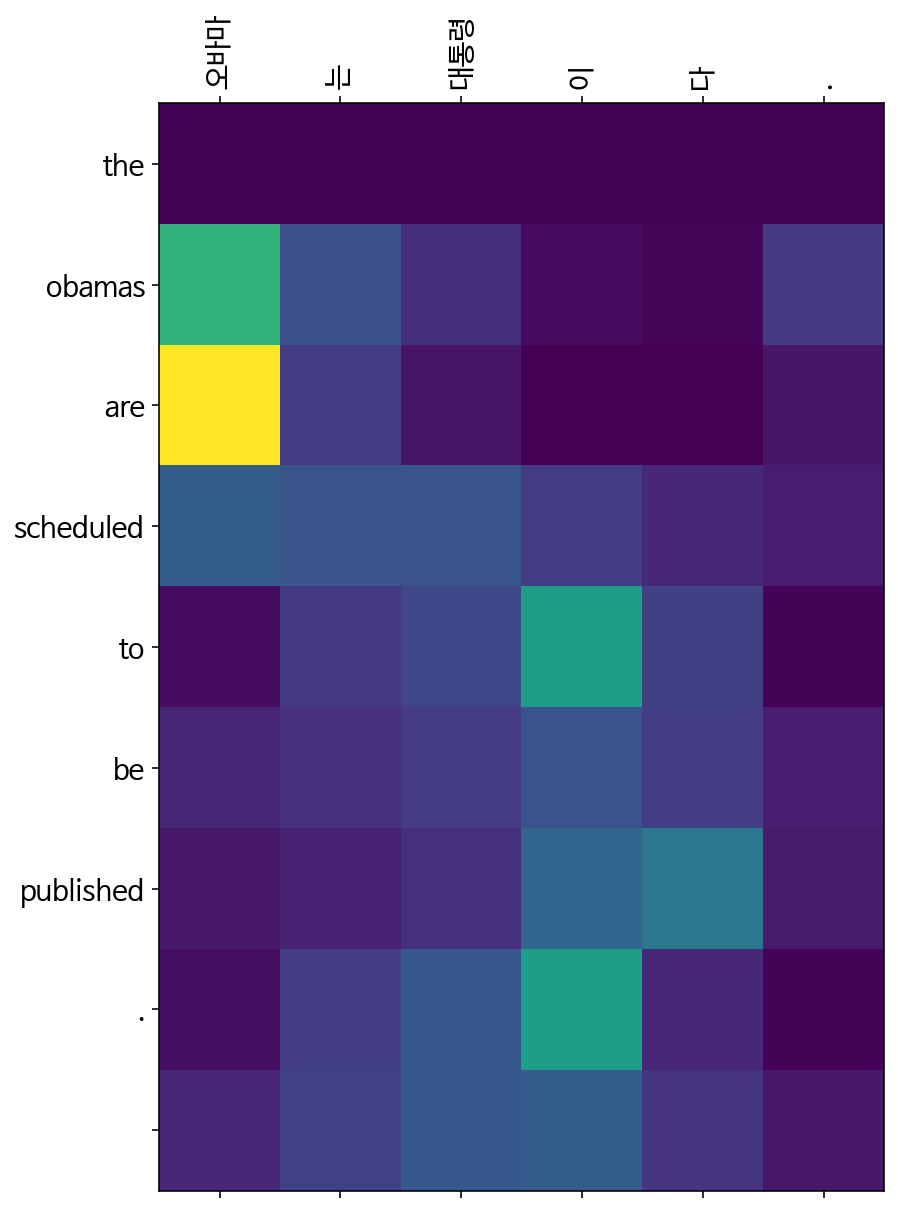

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the children are  up in the  .  <end> 


/tmp/ipykernel_56/3465842361.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_56/3465842361.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


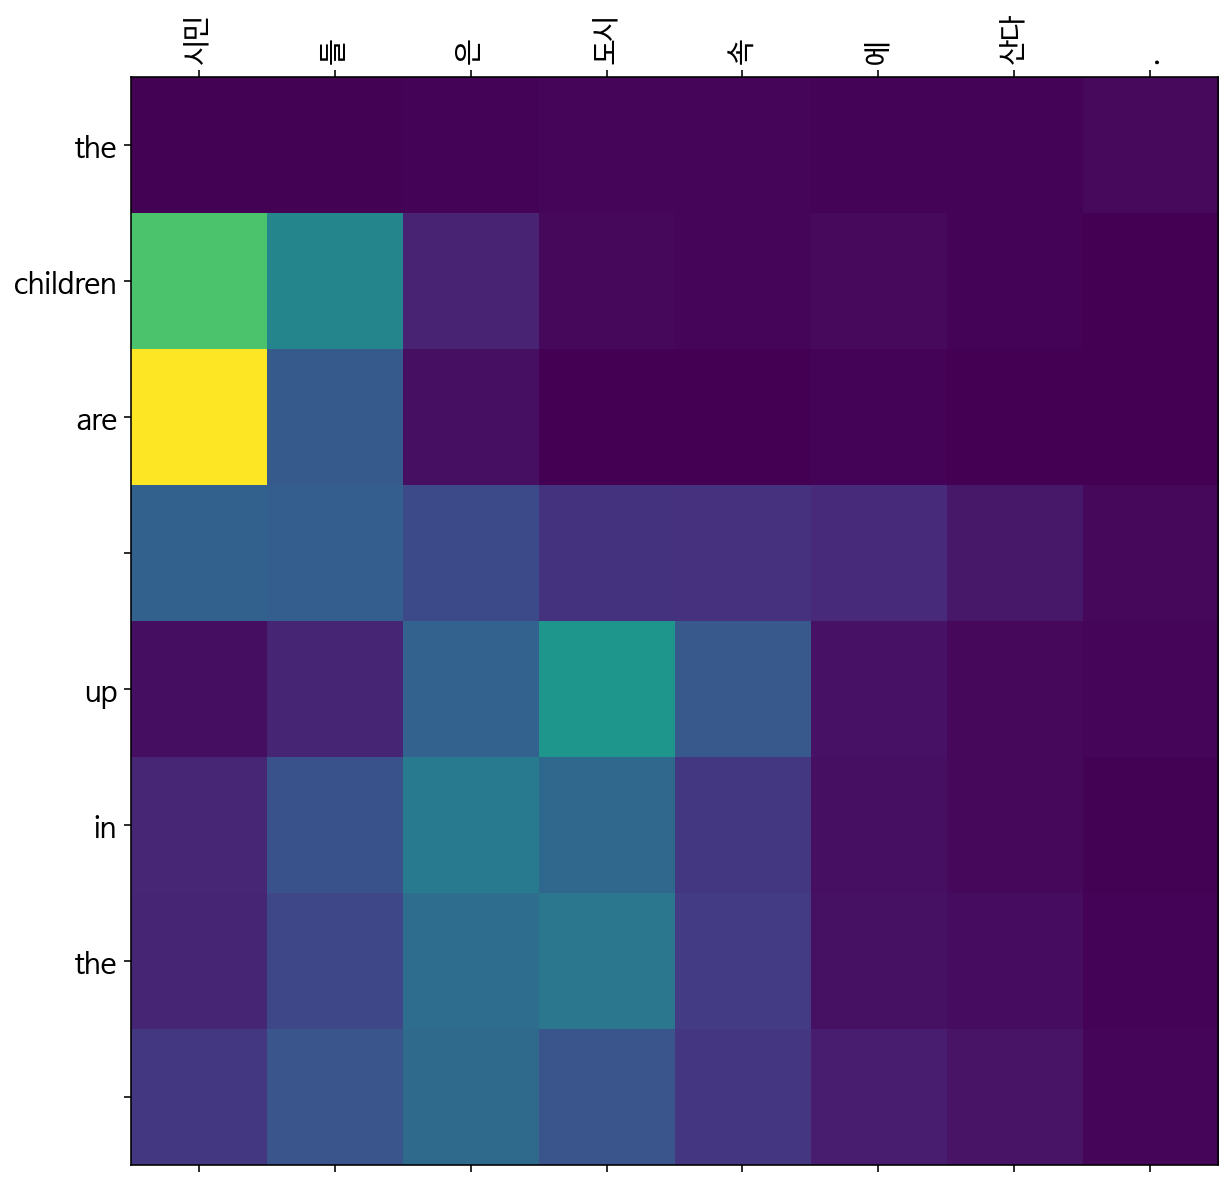

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the pool  <end> 


/tmp/ipykernel_56/3465842361.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_56/3465842361.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


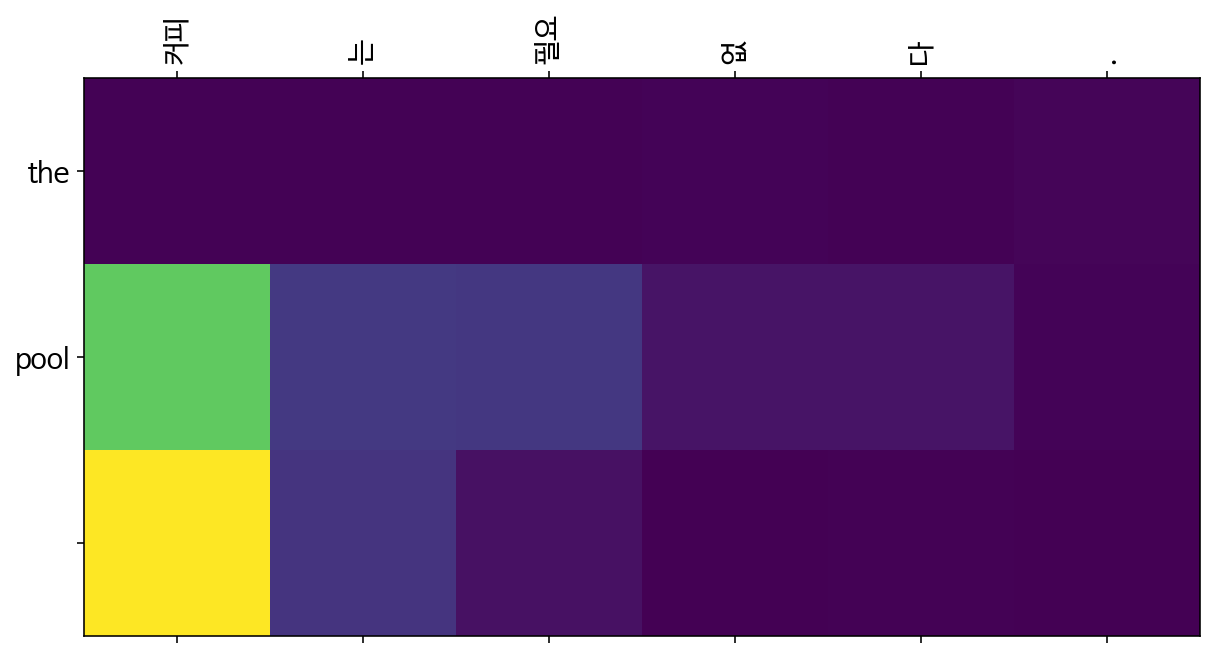

In [ ]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the identities of the dead bodies were wounded .  <end> 


/tmp/ipykernel_56/3465842361.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_56/3465842361.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


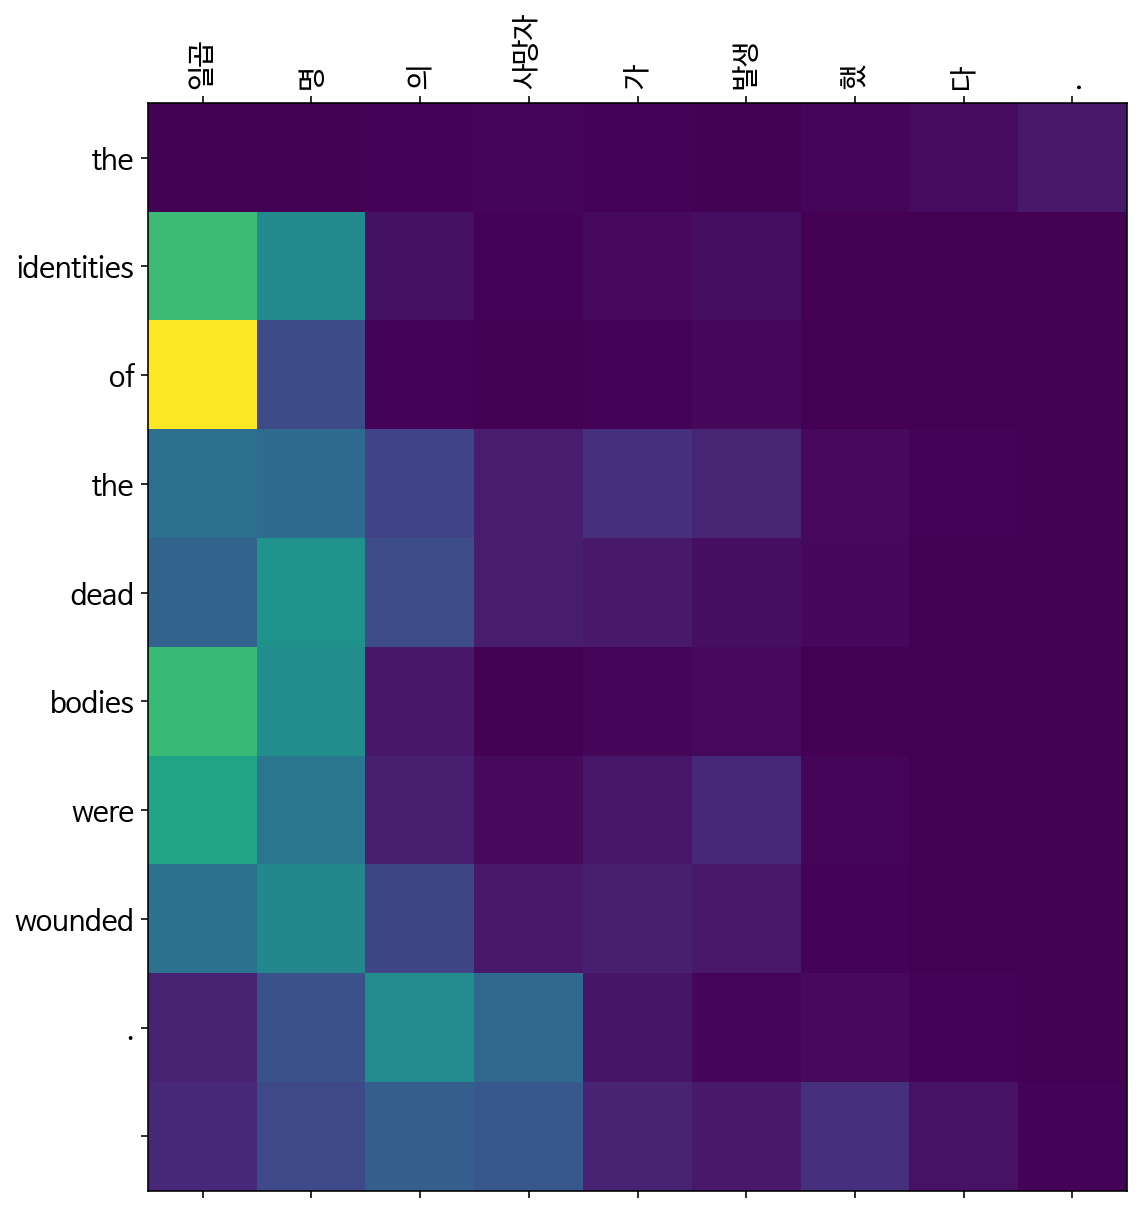

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 회고

이번 노드에서는 Sequence to Sequence 방식과 어텐션을 이용해 번역기를 만들었다.

기존의 LSTM 레이어를 통한 RNN 방식은 몇 가지 문제가 있었다. 바로 데이터를 병렬적으로 받아들일 수 없어서 학습이 오래 걸린다는 것과 고정된 크기의 컨텍스트 벡터를 사용하기 때문에 너무 긴 문장에서는 성능이 떨어진다는 것이었다.

따라서 이 문제를 해결하기 위해 어텐션을 활용했고 그 덕에 번역의 과정 또한 확인할 수 있게 되었다. 마지막 번역 결과에서 초록색으로 칠해진 칸이 관련도가 높다는 뜻이고 어두운 색은 관련이 없다는 뜻이다.

결과를 보면 전반적으로 나쁘지 않게 번역되었으나 당연히 제대로 된 번역은 아니었다. 하지만 사용 데이터가 2만개도 되지 않았다는 점을 감안하면 어텐션의 힘을 확인할 수 있었다고 생각한다. 단어장의 크기는 1만개로 사용했는데 아래 레퍼런스에 따르면 데이터의 크기가 작을 때는 단어장의 크기 또한 작아져야 성능이 좋다고 한다. 하지만 이번 노드에서는 최소 1만개를 설정해두고 있으므로 그 값을 썼다. 임베딩 레이어와 히든 레이어의 크기 등 또한 바꿔보고 싶었으나 학습이 제대로 되지 않는 경우가 자주 생겨 많은 시도를 비교해볼 수 없었다.

그 외에도 데이터의 크기를 제한한 점이 아쉬웠다. 전체 데이터의 크기는 9만개 이상이었으므로 훨씬 더 많은 데이터를 사용할 수 있었다고 생각한다. 하지만 2만개도 채 되지 않는 데이터의 크기로도 한 번 학습을 하는데 시간이 적지 않게 소모되었으므로 여기서 전체 데이터를 전부 사용했다면 너무 학습이 오래 걸리게 되었을 것이다.

# Reference

https://stellarway.tistory.com/45 적절한 vocab size 에 대하여  
https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size embedding size 결정하는 법
 